In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import manifold
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

from time import time
import seaborn as sns
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn import datasets, linear_model
import sys

In [3]:
df = pd.read_csv('3690_all.tsv', sep='\t',index_col=0)
#df.set_index(df["Unnamed: 0"], inplace=True)
df.head()

,MGS_LEVEL,TSPAN6,FUCA2,GCLC,SEMA3F,ANKIB1,BAD,CD99,MAD1L1,TMEM176A,...,PCBP2-OT1,RP11-557N21.1,CTC-325H20.8,CTD-2021K4.1,RP11-681B3.4,RP11-118G23.3,RP11-624J6.2,RP11-9J18.1,RP11-793J2.1,RP11-419I17.1
205_2,2,0.413827,0.374748,0.692236,0.364232,0.616166,0.230769,0.535113,0.454147,0.315069,...,0.342184,0.142460,0.222006,0.611190,0.658467,0.148492,0.205038,0.139876,0.371926,0.175608
251_1,1,0.236678,0.227783,0.243099,0.393270,0.343130,0.262310,0.337588,0.514919,0.201911,...,0.154700,0.188546,0.293826,0.307780,0.476310,0.147397,0.266822,0.000000,0.276888,0.172579
474_3,3,0.187834,0.153301,0.279470,0.455109,0.330394,0.282329,0.174306,0.406849,0.161702,...,0.199962,0.375112,0.328818,0.532773,0.397823,0.366557,0.388154,0.121169,0.330521,0.161044
178_4,4,0.105215,0.099118,0.202273,0.345651,0.414352,0.157432,0.184713,0.377494,0.099135,...,0.192456,0.078291,0.396525,0.190392,0.357346,0.122410,0.468692,0.283670,0.275939,0.428593
313_1,1,0.261500,0.176303,0.287437,0.137330,0.541634,0.081213,0.153164,0.194455,0.206654,...,0.126085,0.299956,0.350583,0.250570,0.607989,0.312656,0.121023,0.337880,0.626487,0.160516


In [24]:
## separate control vs patient
control = df[df.MGS_LEVEL == 1]
stage2_patient = df[df.MGS_LEVEL == 2]
stage3_patient = df[df.MGS_LEVEL == 3]
stage4_patient = df[df.MGS_LEVEL == 4]

In [23]:
def compute_lasso(control, patient):
    ## 0 if stage is 1, 1 if stage is 1,2,3
    control["binary"] = 0
    patient["binary"] = 1
    
    ## merge two datasets vertically and remove mgs level
    new_df = control.append(patient, ignore_index=True)
    new_df = new_df.iloc[:,2:]
    
    ## split into X, Y variables
    X_train = new_df.iloc[:,:-1]
    y_train = new_df.iloc[:,-1]
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    
    sel_ = SelectFromModel(LogisticRegression(penalty='l1')) ##penalty is lasso regression
    sel_.fit(scaler.transform(X_train), y_train)
    
    lasso = linear_model.Lasso()
    cv_results = cross_validate(lasso, X_train, y_train)
    cv_results.keys()
    #cross_validate(sel2_, scaler.transform(X_train), y_train)
    
    ## Make a list of with the selected features.
    selected_feat = X_train.columns[(sel_.get_support())]
    
    ## Identifying the significant features
    sig_feats = X_train.columns[(sel_.estimator_.coef_ != 0).ravel().tolist()]

    
    ## Identifying the removed features
    removed_feats = X_train.columns[(sel_.estimator_.coef_ == 0).ravel().tolist()]
    
    ## Removing the features from training
    ## 453 patients, select important features
    X_train_selected = sel_.transform(X_train)
    X_train_selected = np.transpose(X_train_selected)
    
    # get the dataframe for selected genes
    X_train_selected
    lasso_filtered = pd.DataFrame(data=X_train_selected, index=sig_feats)
    
    return lasso_filtered, sig_feats

In [25]:
s2_lasso_filtered, s2_sig_feats = compute_lasso(control, stage2_patient)
s3_lasso_filtered, s3_sig_feats = compute_lasso(control, stage3_patient)
s4_lasso_filtered, s4_sig_feats = compute_lasso(control, stage4_patient) 

/Users/minjunp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/minjunp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/minjunp/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' 

# See how many genes overlap across different stages

In [31]:
## all stages overlap
count = 0
for i in s2_sig_feats:
    if i in s3_sig_feats and i in s4_sig_feats:
        count += 1
count

9

In [33]:
## stage 2 and 3 overlap
count = 0
for i in s2_sig_feats:
    if i in s3_sig_feats:
        count += 1
count

37

In [34]:
## stage 2 and 4 overlap
count = 0
for i in s2_sig_feats:
    if i in s4_sig_feats:
        count += 1
count

25

In [35]:
## stage 3 and 4 overlap
count = 0
for i in s3_sig_feats:
    if i in s4_sig_feats:
        count += 1
count

19

# plot filtered genes and correlation matrix

In [36]:
def plot_lasso(lasso_filtered):
    #althought did not show very clear cluster, at some cluster, there are no of stage 4 patients
    g = sns.clustermap(lasso_filtered,figsize = (40,30))
    g.fig.suptitle('Gene_patient_Clusterheatmap')
    
    #correlation, might help for variable selection, since some genes might be have similiar effect, could help reduce dimension
    corr = lasso_filtered.corr()
    sns.clustermap(corr,cmap="mako")

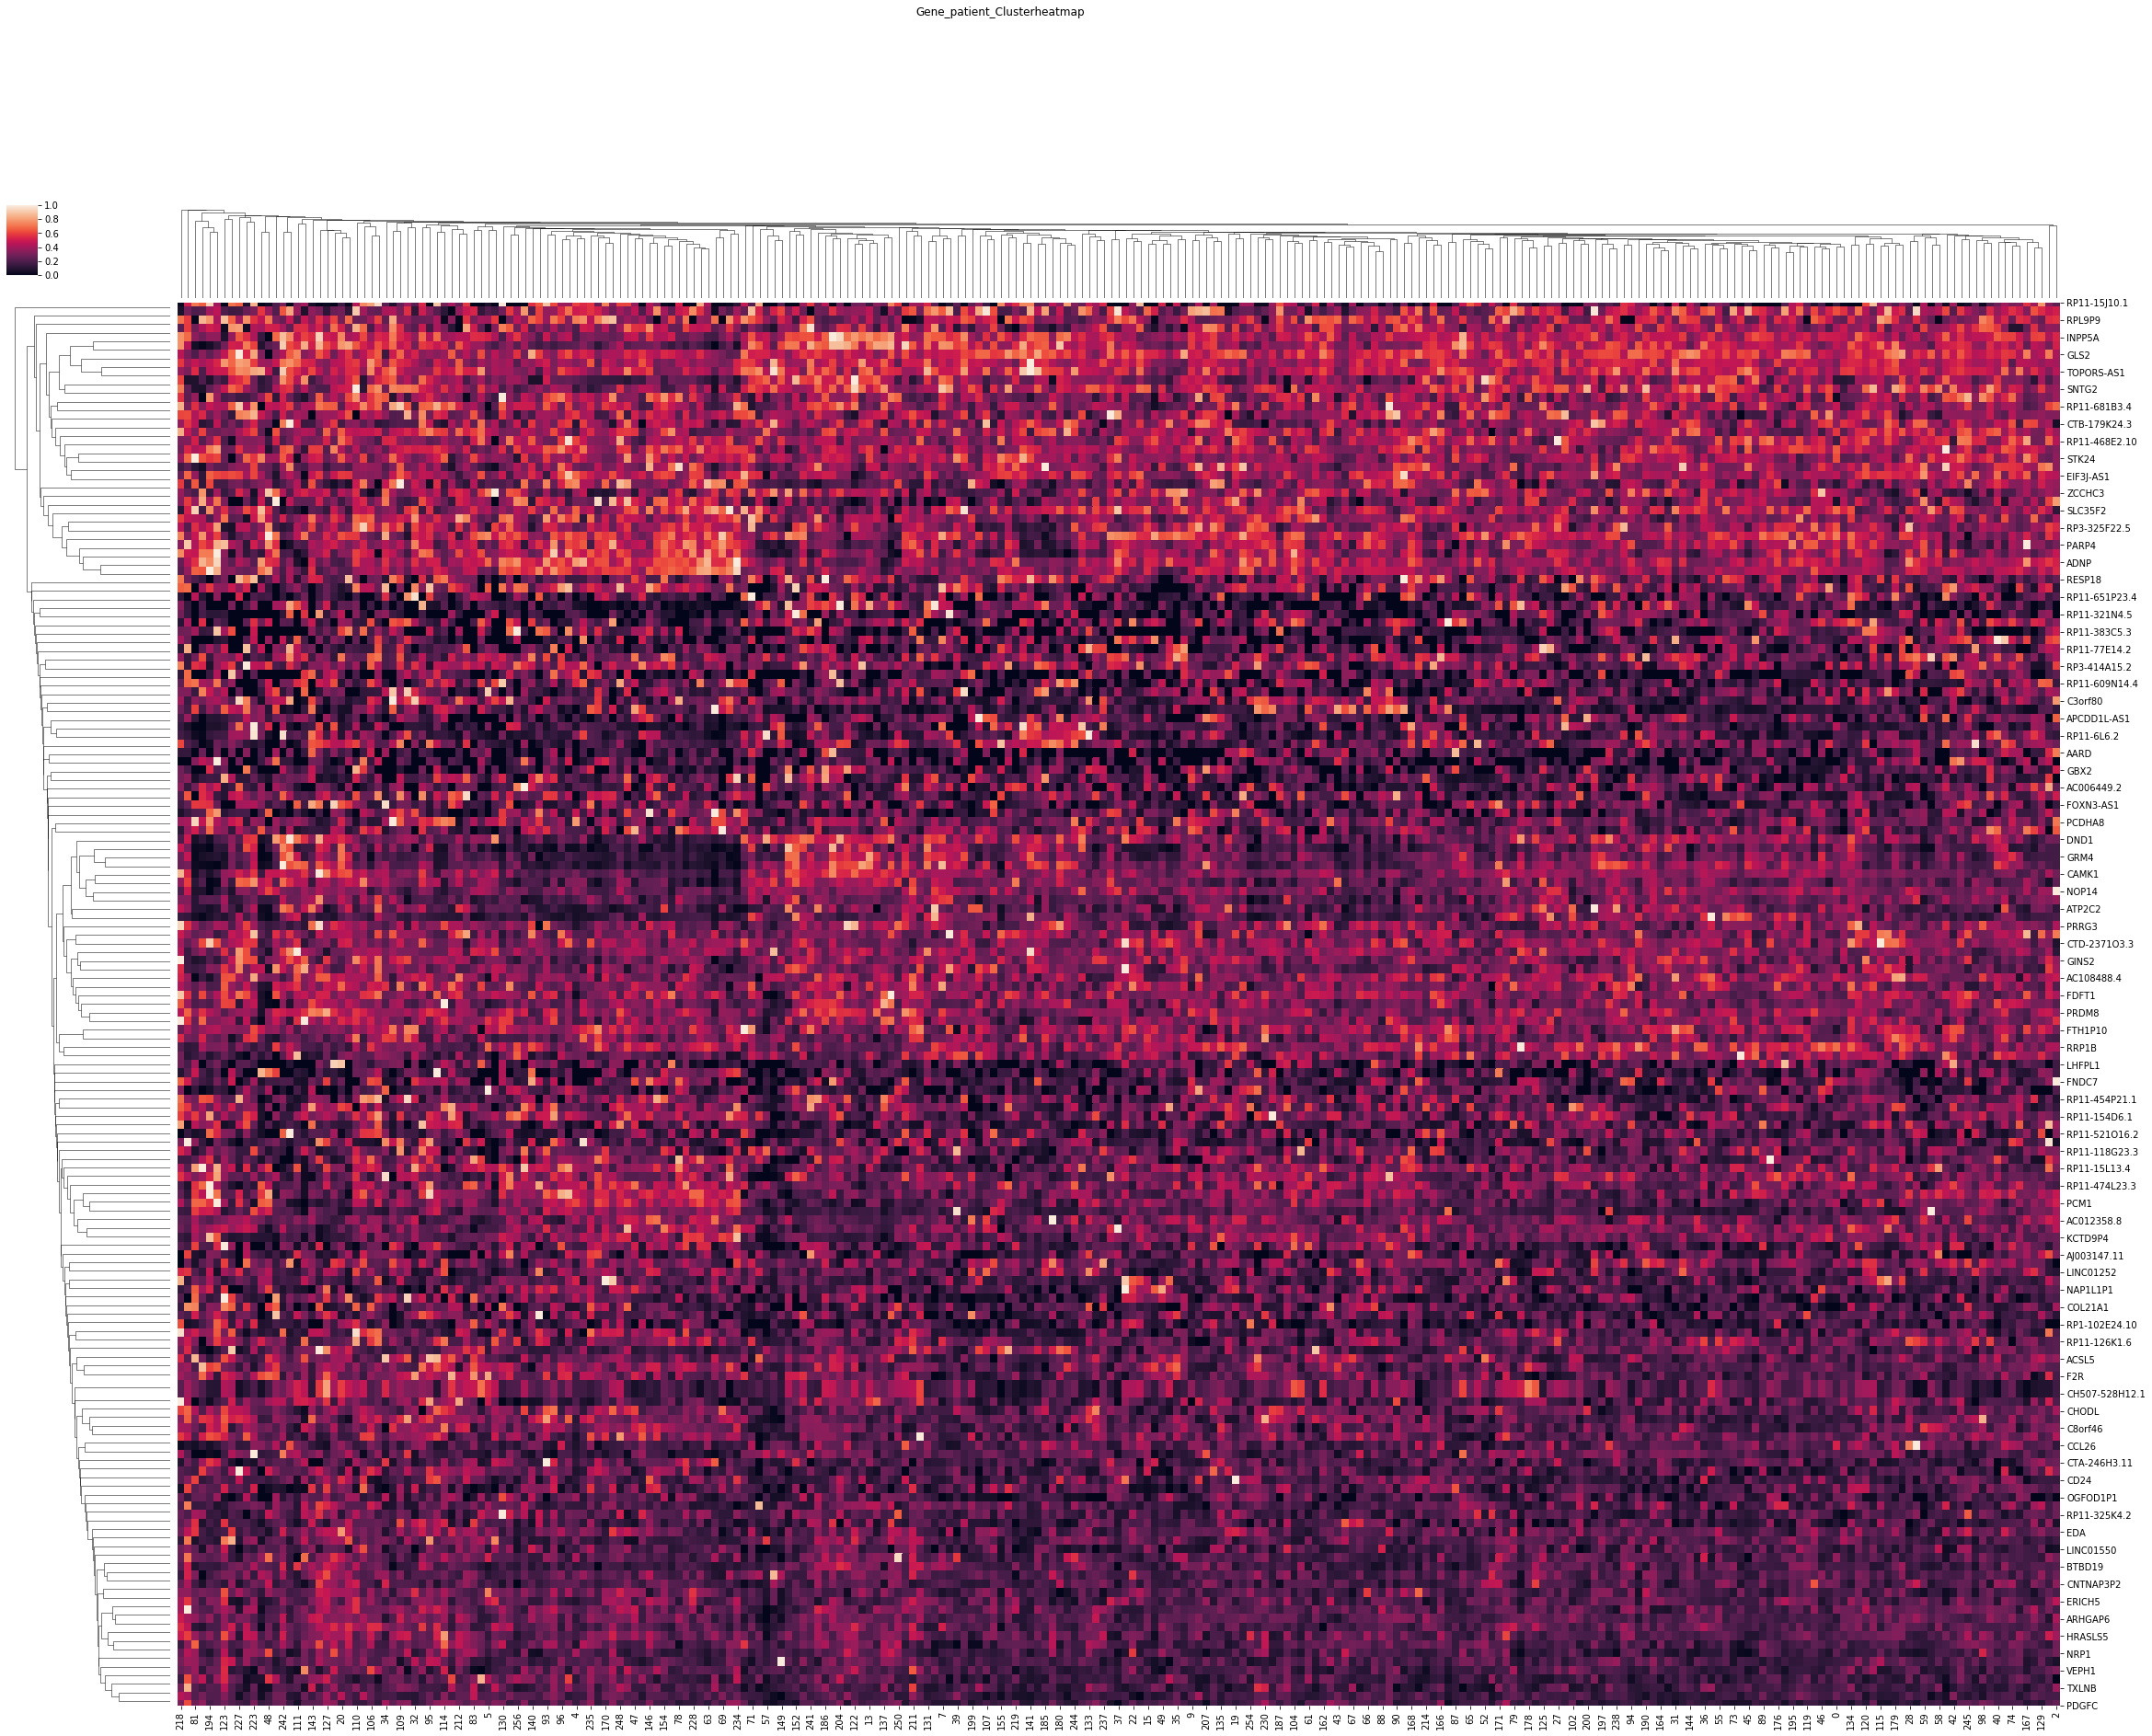

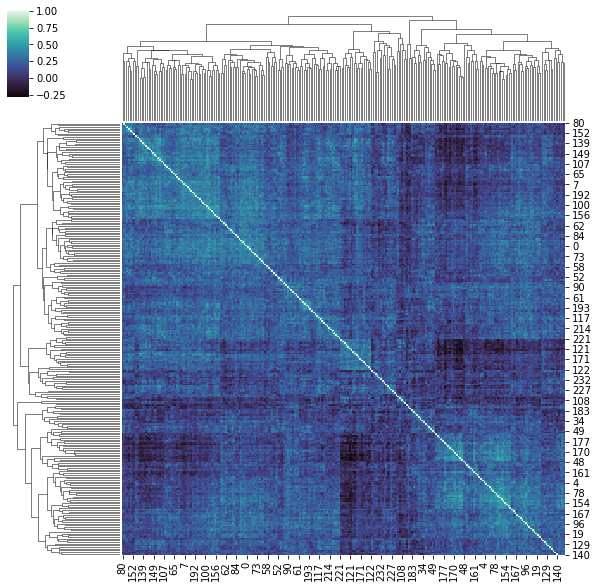

In [37]:
plot_lasso(s2_lasso_filtered)

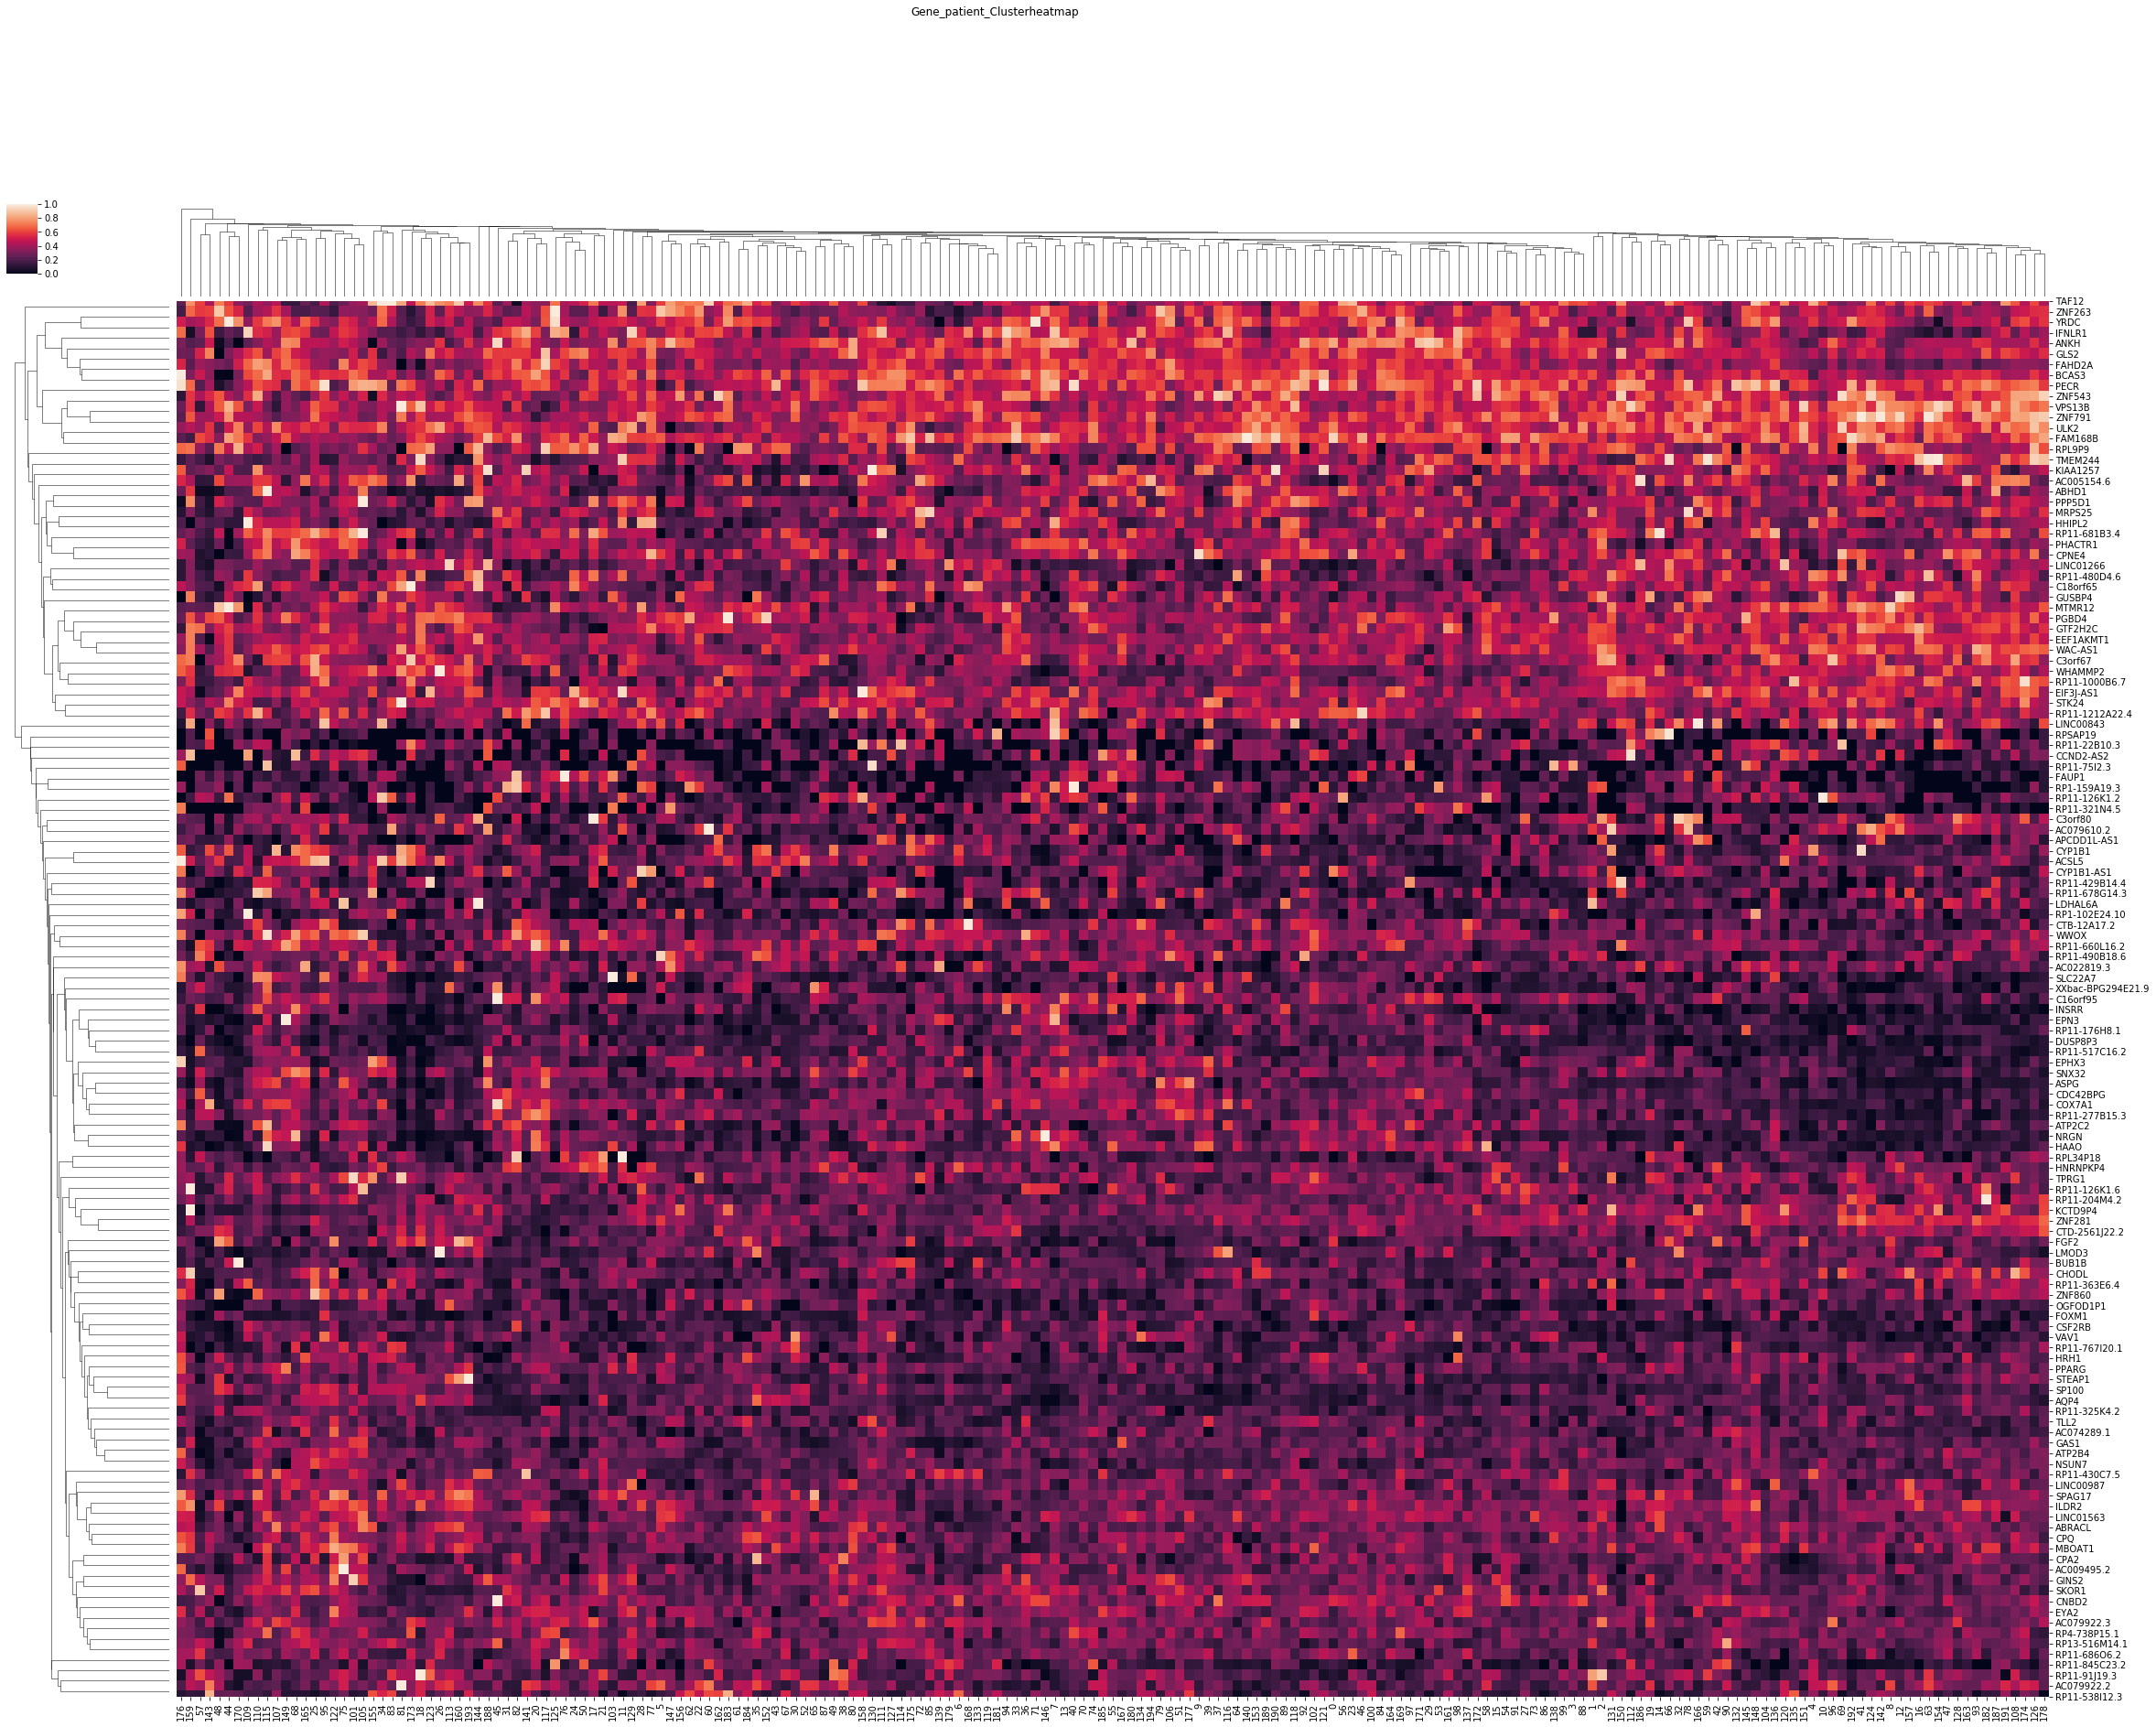

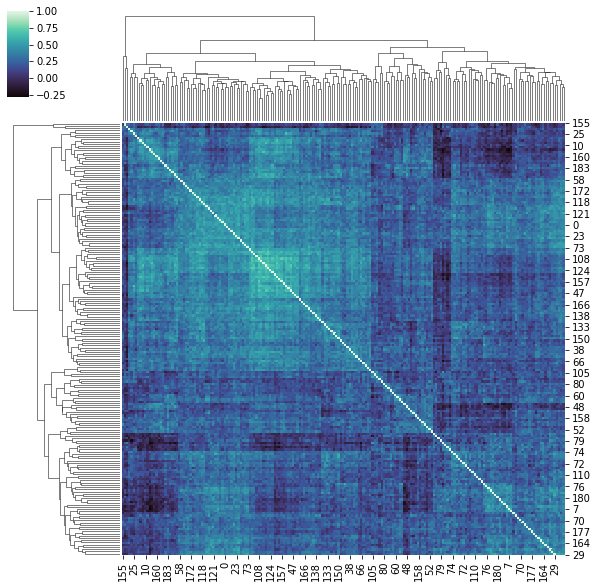

In [38]:
plot_lasso(s3_lasso_filtered)

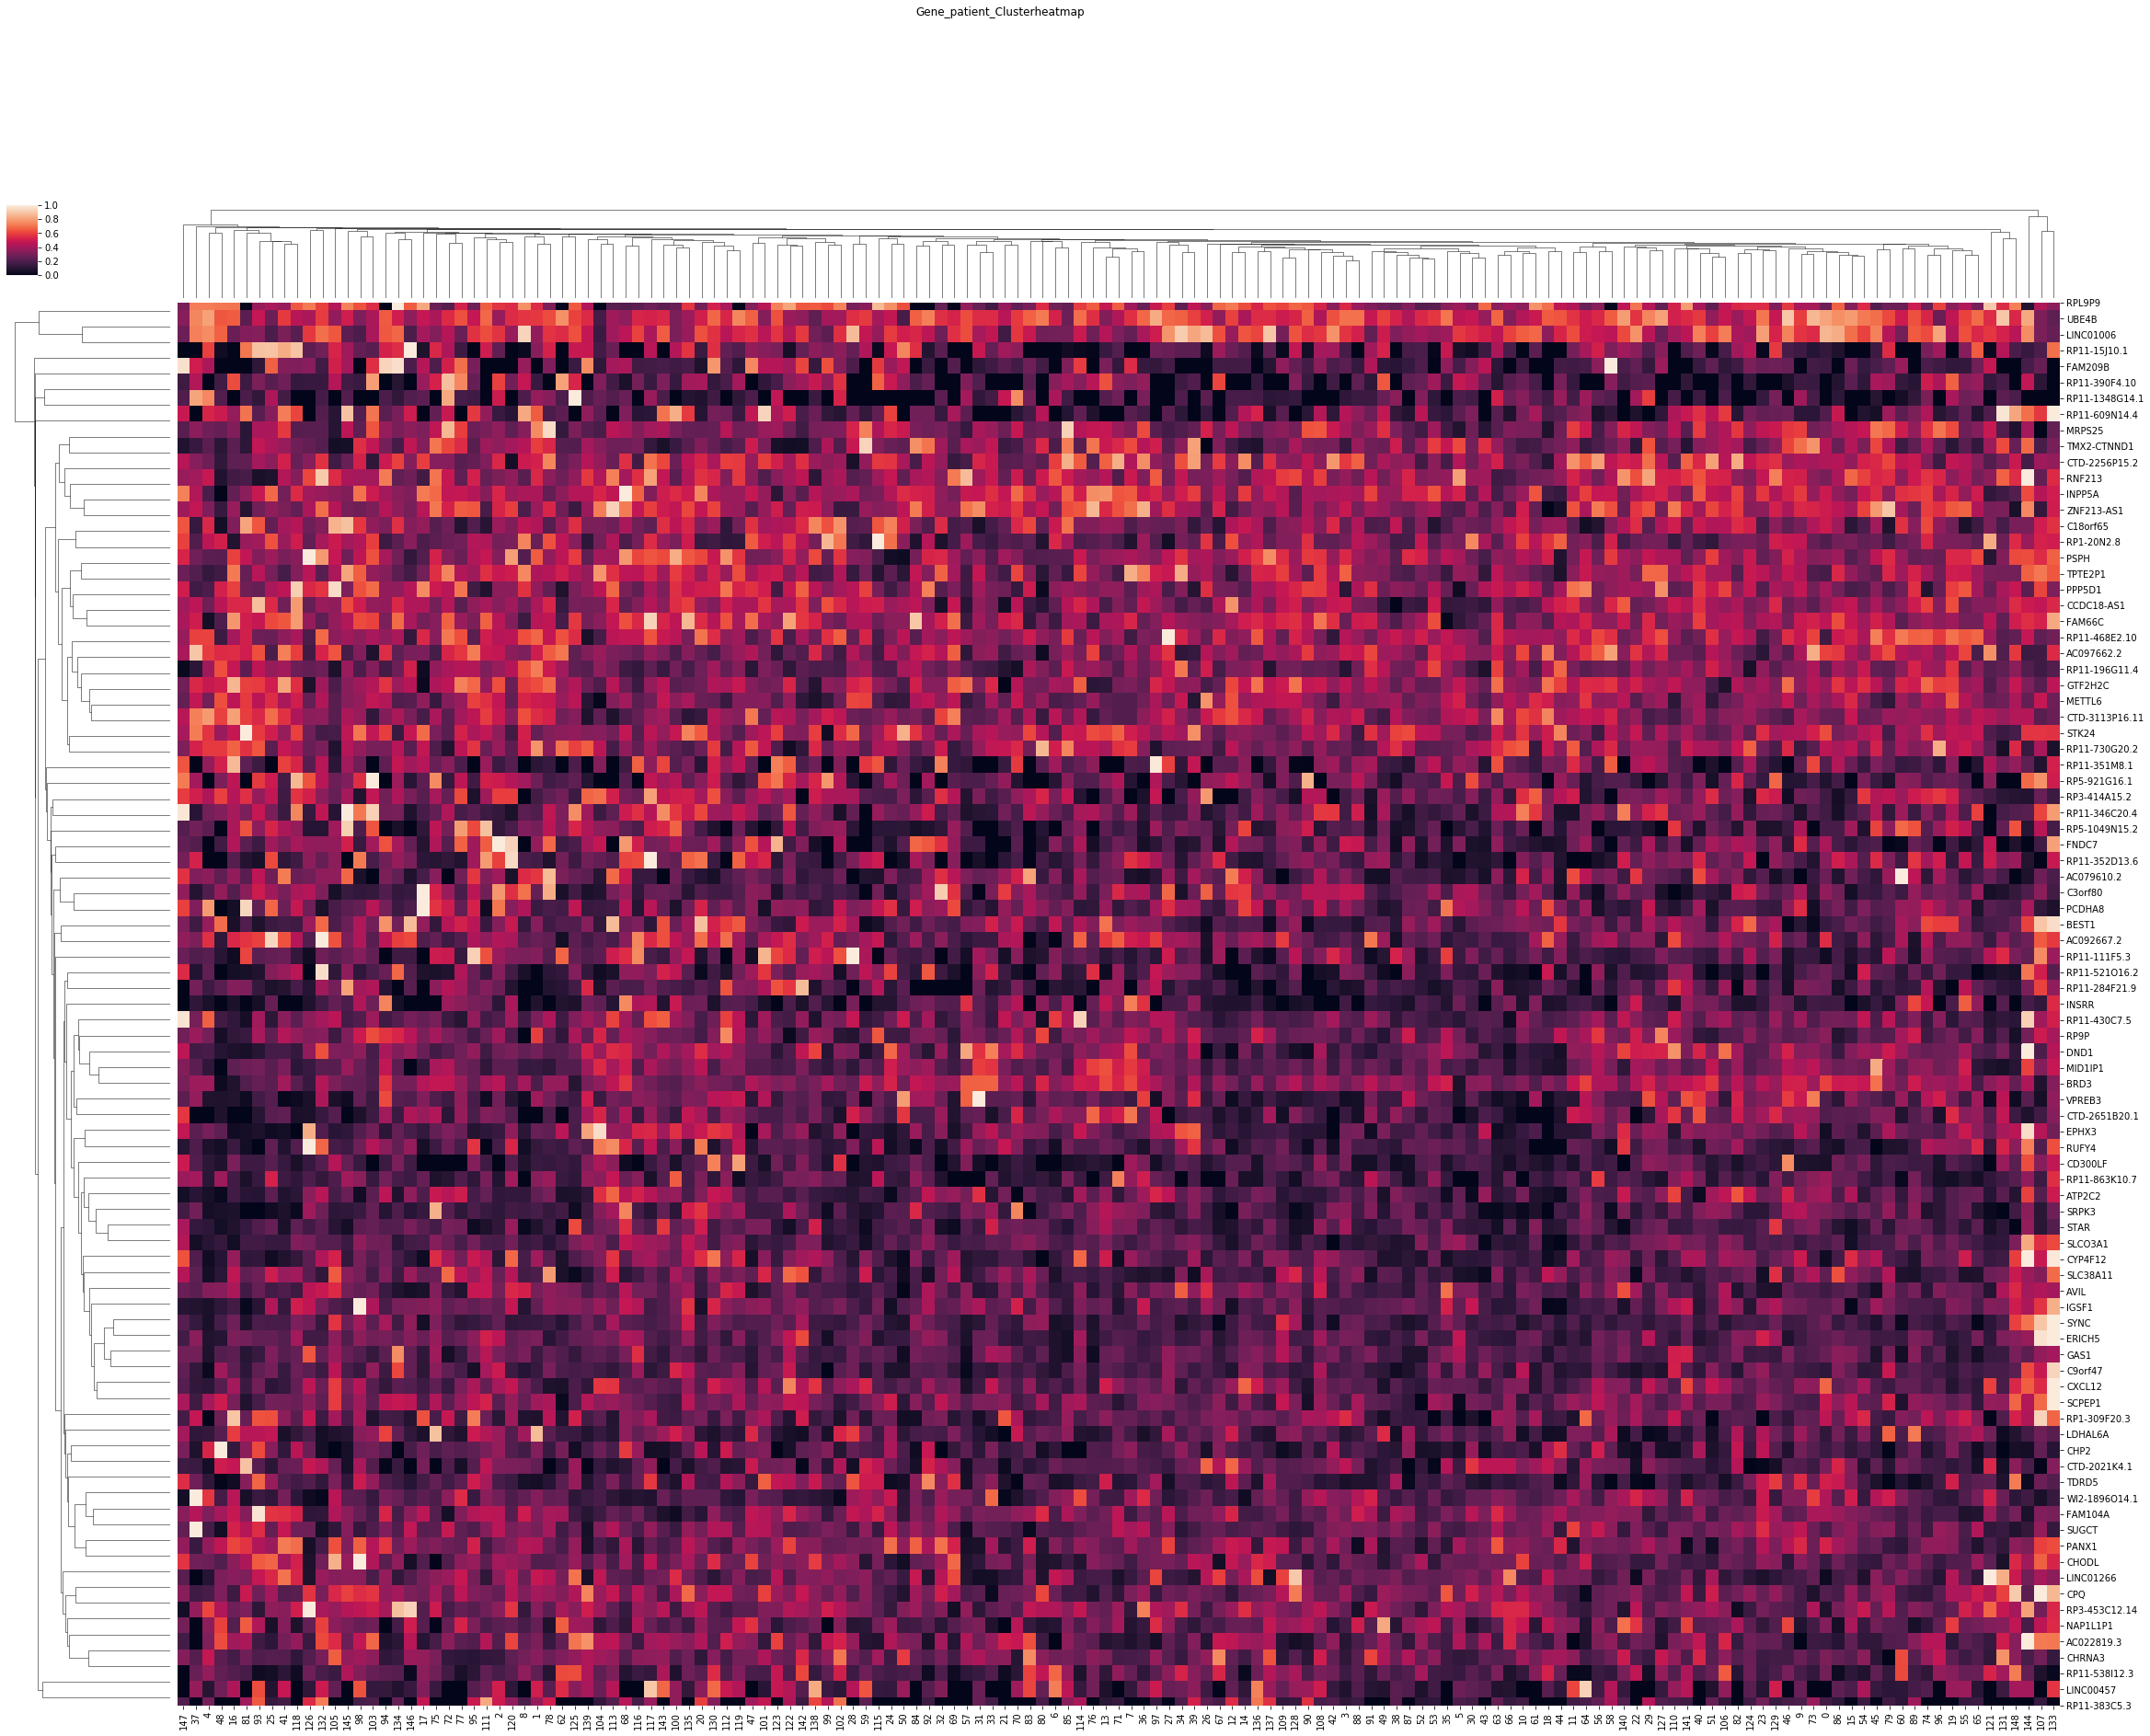

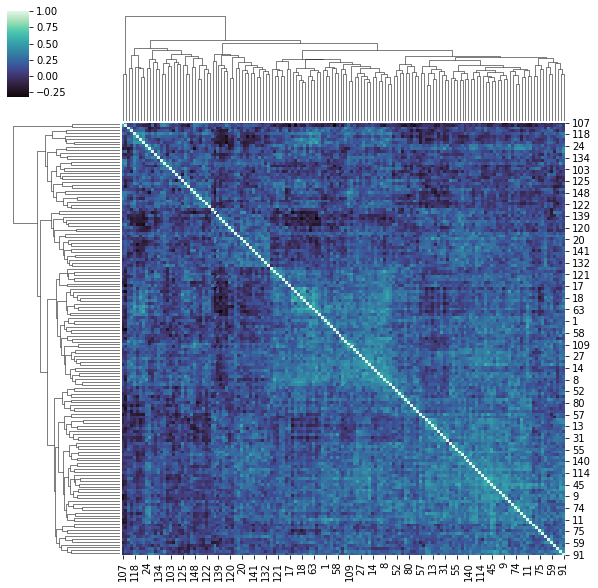

In [39]:
plot_lasso(s4_lasso_filtered)